# Keras Simple autopilot Demo RObot!

In [4]:
# needed for matplotlib in jupyter notebook
%matplotlib inline

# import required modules
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import pandas as pd
import os

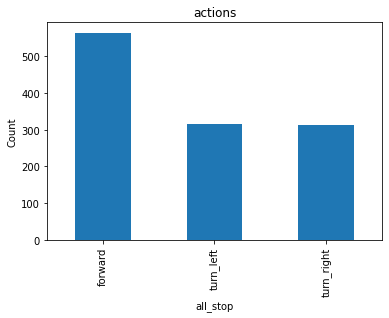

In [25]:
# prepare data
data = pd.read_csv(os.path.join('..', 'source', 'logs', '20200904-165427.log'))
data.shape
data = data[data.all_stop != 'all_stop']
data = data[data.all_stop != 'backward']
data_forward_length =  data[data.all_stop == 'forward'].shape[0]
data_random_forward = data[data.all_stop == 'forward'].sample(n=int(data_forward_length*0.9))
data.drop(data_random_forward.index,inplace=True)
data['all_stop'].value_counts().plot(kind='bar')
plt.title('actions')
plt.xlabel('all_stop')
plt.ylabel('Count')

image_size = 64

data = data.sample(frac=1).reset_index(drop=True)



In [26]:
# split into training and test data (10% test data)
data_test = data.sample(n=int(data.shape[0]/10))
data.drop(data_test.index,inplace=True)

#labels

conv_labels = [0 if values == 'forward' else values for values in data.all_stop ]
conv_labels = [1 if values == 'turn_left' else values for values in conv_labels ]
conv_labels = [2 if values == 'turn_right' else values for values in conv_labels ]

labels = conv_labels

#labels test 
conv_labels = [0 if values == 'forward' else values for values in data_test.all_stop ]
conv_labels = [1 if values == 'turn_left' else values for values in conv_labels ]
conv_labels = [2 if values == 'turn_right' else values for values in conv_labels ]

labels_test = conv_labels
print(len(labels_test))
print(len(labels))

119
1074


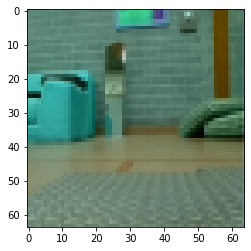

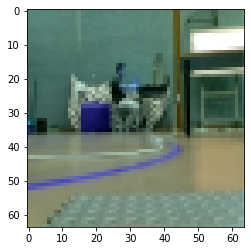

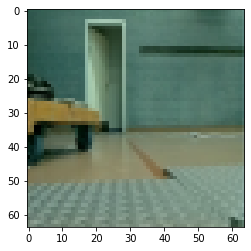

In [27]:
# convert image data
train = data.drop([ 'all_stop'],axis=1).values
test = data_test.drop([ 'all_stop'],axis=1).values

train = train.reshape(train.shape[0],image_size,image_size,3)
test = test.reshape(test.shape[0],image_size,image_size,3)

for i in range(0,3):
    plt.imshow(train[i])
    plt.show()

## Data preparation

In [28]:
# create a train and test set

x_train = train.astype('float32') / 255
x_test = test.astype('float32') / 255

# convert classes to one-hot encoding
num_classes = 3
y_train = keras.utils.to_categorical(labels, num_classes)
y_test = keras.utils.to_categorical(labels_test, num_classes)
print("one-hot labels:\n", y_train[:3])


one-hot labels:
 [[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


## Training

In [29]:
# create model
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(image_size, image_size, 3)),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               14745728  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [ ]:
# fit model to training data
model.fit(x_train, y_train, validation_split=0.2, epochs=10)

Epoch 1/10
 4/27 [===>..........................] - ETA: 4s - loss: 4.0482 - accuracy: 0.3281

## Evaluation

In [22]:
# evaluate model
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score)

4/4 [==============================] - 0s 32ms/step - loss: 0.3216 - accuracy: 0.9346
Test accuracy: [0.32160353660583496, 0.9345794320106506]


In [23]:
model.save(os.path.join('..', 'models', 'robot_model.h5'))